# Wrangle Business Data
<p>This wrangling will focus on stripping down the data set from the nearly 175,000 businesses to only Restaurants in Arizona.  This subset will allow our text processing to focus on finding underlying topics in across a single domain.</p>

## Step 0: Import packages and establish chart output standards

In [1]:
import numpy as np
import pandas as pd
import datetime
import json
import itertools
from collections import Counter

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 15

FIG_SIZE = (15,6)

DO_WRITE_CHARTS = True

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

def time_marker(text=''):
    print('[{}] {}'.format(datetime.datetime.now().time(), text.lower()))

# Step 1: Load Business Data
<p>Data is provided in well structured JSON format and includes many columns of useful data.  This analysis is focused on Restaurants in Arizona only, and as a first cleaning step, only json records with the `state` variable `AZ` will be kept.</p>

In [3]:
data = pd.DataFrame()
source_data_file = '../source_data/business.json'

# read file line by line and only include businesses in Arizona
business_data = []
with open(source_data_file, 'r') as business_file:
    for i, busininess_json in enumerate(business_file):
        
        business = json.loads(busininess_json)
        
        if business['state'] == 'AZ':
            business_data.append(business)
            
        if i % 10000 == 0 and i != 0:
            time_marker('\tfound {:d}/{:d} Arizona Businesses so far {:2.4f} '.format(len(business_data),i,len(business_data)/(i+1)*100.))
            
print('Selected {:d} Arizona Businesses from {:d} total businesses'.format(len(business_data), i))
business_df = pd.DataFrame(business_data)
print('Found {:d} restaurant reviews'.format(business_df.shape[0]))

[19:27:27.097774] 	found 2937/10000 arizona businesses so far 29.3671 
[19:27:27.516410] 	found 5772/20000 arizona businesses so far 28.8586 
[19:27:27.827832] 	found 8686/30000 arizona businesses so far 28.9524 
[19:27:28.135571] 	found 11743/40000 arizona businesses so far 29.3568 
[19:27:28.437628] 	found 14582/50000 arizona businesses so far 29.1634 
[19:27:28.749028] 	found 17585/60000 arizona businesses so far 29.3078 
[19:27:29.146650] 	found 20397/70000 arizona businesses so far 29.1382 
[19:27:29.473541] 	found 23271/80000 arizona businesses so far 29.0884 
[19:27:29.777678] 	found 26226/90000 arizona businesses so far 29.1397 
[19:27:30.080218] 	found 29193/100000 arizona businesses so far 29.1927 
[19:27:30.396117] 	found 32178/110000 arizona businesses so far 29.2525 
[19:27:30.717796] 	found 35172/120000 arizona businesses so far 29.3098 
[19:27:31.134990] 	found 38081/130000 arizona businesses so far 29.2929 
[19:27:31.418370] 	found 41144/140000 arizona businesses so far

In [4]:
business_df.head(3)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,"4855 E Warner Rd, Ste B9","{'AcceptsInsurance': True, 'ByAppointmentOnly'...",FYWN1wneV18bWNgQjJ2GNg,"[Dentists, General Dentistry, Health & Medical...",Ahwatukee,"{'Friday': '7:30-17:00', 'Tuesday': '7:30-17:0...",1,33.330690,-111.978599,Dental by Design,,85044,22,4.0,AZ
1,"6025 N 27th Ave, Ste 1",{},KQPW8lFf1y5BT2MxiSZ3QA,"[Departments of Motor Vehicles, Public Service...",Phoenix,{},1,33.524903,-112.115310,Western Motor Vehicle,,85017,18,1.5,AZ
2,"5000 Arizona Mills Cr, Ste 435","{'BusinessAcceptsCreditCards': True, 'Restaura...",8DShNS-LuFqpEWIp0HxijA,"[Sporting Goods, Shopping]",Tempe,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",0,33.383147,-111.964725,Sports Authority,,85282,9,3.0,AZ


In [5]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52214 entries, 0 to 52213
Data columns (total 15 columns):
address         52214 non-null object
attributes      52214 non-null object
business_id     52214 non-null object
categories      52214 non-null object
city            52214 non-null object
hours           52214 non-null object
is_open         52214 non-null int64
latitude        52214 non-null float64
longitude       52214 non-null float64
name            52214 non-null object
neighborhood    52214 non-null object
postal_code     52214 non-null object
review_count    52214 non-null int64
stars           52214 non-null float64
state           52214 non-null object
dtypes: float64(3), int64(2), object(10)
memory usage: 6.0+ MB


# Step 2: Drop Unnecessary columns
<p>The data set includes a lot of interesting data, much of which we do not need for this analysis.  We are keeping a subset of columns and tossing out all others.</p>
<ul>
    <li><b>attributes:</b> A dictionary of business details, such as smoking, parking, wether a business accepts credit cards and other information.</li>
    <li><b>latitude:</b> The latitude GPS Coordinate of the business</li>
    <li><b>longitude:</b> The longitude GPS Coordinate of the business</li>
    <li><b>hours:</b> A dictionary of day_of_week:'business_open-business_time' records. keys and values represented as strings.</li>
    <li><b>state:</b> The state, we already removed non Arizona locations, so this column provides no additional information</li>
    <li><b>address:</b> The address of the business</li>
    <li><b>neighborhood:</b> The neighborhood the business is located in</li>
    
</ul>

In [6]:
business_df = business_df.drop(['attributes', 'latitude', 'longitude', 'hours', 'state', 'neighborhood'], axis=1)

In [7]:
business_df.head(3)

,address,business_id,categories,city,is_open,name,postal_code,review_count,stars
0,"4855 E Warner Rd, Ste B9",FYWN1wneV18bWNgQjJ2GNg,"[Dentists, General Dentistry, Health & Medical...",Ahwatukee,1,Dental by Design,85044,22,4.0
1,"6025 N 27th Ave, Ste 1",KQPW8lFf1y5BT2MxiSZ3QA,"[Departments of Motor Vehicles, Public Service...",Phoenix,1,Western Motor Vehicle,85017,18,1.5
2,"5000 Arizona Mills Cr, Ste 435",8DShNS-LuFqpEWIp0HxijA,"[Sporting Goods, Shopping]",Tempe,0,Sports Authority,85282,9,3.0


# Step 3: Lowercase and Sanitize Categories Lists
<p>`categories` consists of a list of business categories used to classify the business location.  As a first cleaning pass we set all categories to lower case and replace spaces with underscores.</p>

In [8]:
business_df['categories'] = business_df.categories.apply(lambda x: [c.lower().replace(' ','_') for c in x])

business_df['address'] = business_df.address.apply(lambda x: x.replace(',', ''))

# Step 4: Parse `categories` column and keep only restaurants

<ol> Creating a dataframe of only restaurants is done with the following steps.
    <li>A flat list of restaaurant categories was manually created and loaded from a text file.</li>
    <li>A flat list of all business categories is created by generating a flat list of unique values in the lists found in `categories` column</li>
    <li>Each business record is inspected and if the cateogires list of that business includes any value found in the `drop_category_list` the business_id is recorded to a list called `bid_to_drop`.</li>
    <li>A `restaurant_df` is created by removing businesses found in the drop list from the `business_df` data frame.</li>
</ol>

<p>This reduces the business data frame from 52214 businesses to just 7066 restaurants that will be used in this analysis.</p>

In [9]:
# load file of known restuarant categories
with open('../clean_data/restaurant_categories.txt', 'r') as f:
    restaurant_categories = f.readlines()
restaurant_categories = [x.strip() for x in restaurant_categories]

In [10]:
# create list of all categories that are NOT restaurants
all_categories = list(itertools.chain.from_iterable(business_df.categories.values))
drop_categories = sorted(list(set(all_categories) - set(restaurant_categories)))

In [11]:
# collect list of business_ids that need to be dropped
bid_to_drop = []
for cat in drop_categories:
    # for each cateory in drop_categories, collect list of all businesses with that cateory
    businesses_with_cat = business_df[business_df.categories.apply(lambda x: cat in x)]
    bid_to_drop.append(businesses_with_cat.business_id)
    

# extract only business_ids from the list of non restaurants    
bids_to_drop = list(set(list(itertools.chain.from_iterable(bid_to_drop))))
time_marker('Dropping {:d} Restaurants'.format(len(bids_to_drop)))

# subset business_df to include only restaurants
restaurant_df = business_df[~business_df.business_id.isin(bids_to_drop)].copy()
restaurant_df.reset_index(inplace=True, drop=True)


[19:27:53.981851] dropping 45148 restaurants


In [12]:
restaurant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7066 entries, 0 to 7065
Data columns (total 9 columns):
address         7066 non-null object
business_id     7066 non-null object
categories      7066 non-null object
city            7066 non-null object
is_open         7066 non-null int64
name            7066 non-null object
postal_code     7066 non-null object
review_count    7066 non-null int64
stars           7066 non-null float64
dtypes: float64(1), int64(2), object(6)
memory usage: 496.9+ KB


In [13]:
restaurant_df.head(5).transpose()

,0,1,2,3,4
address,719 E Thunderbird Rd,777 E Thunderbird Rd Ste 107,1635 E Camelback Rd,10720 E Southern Ave,8140 N Hayden Rd Ste H115
business_id,rDMptJYWtnMhpQu_rRXHng,1WBkAuQg81kokZIPMpn9Zg,iPa__LOhse-hobC2Xmp-Kw,kKx8iCJkomVQBdWHnmmOiA,VdlPZg2NAu8t8GkdbPLecg
categories,"[fast_food, burgers, restaurants]","[burgers, restaurants]","[restaurants, burgers, fast_food]","[restaurants, pizza]","[restaurants, gluten-free, indian, seafood]"
city,Phoenix,Phoenix,Phoenix,Mesa,Scottsdale
is_open,1,1,1,1,1
name,McDonald's,Charr An American Burger Bar,McDonald's,Little Caesars Pizza,Tandoori Times Indian Bistro
postal_code,85022,85022,85016,85209,85258
review_count,10,232,34,4,263
stars,1,3,3,2.5,3.5


# Step 5: Identifying Most Frequent `categories` values
<p>The category term 'restaurant' itself is dropped, as it is included in nearly every restaurant records and is not needed.</p>

In [14]:
def get_category_counts(df, drop_categories=[]):

    ''' Take a business information data frame and return 
        dataframe of categories and counts of that category
    '''
    
    time_marker('Getting list of all categories')
    all_categories = list(itertools.chain.from_iterable(df.categories.values))

    time_marker('Counting occurances of each category')
    category_counts = Counter(all_categories)

    time_marker('Making Data Frame of category counts')
    category_count_df = pd.DataFrame.from_dict(category_counts, orient='index')
    category_count_df.columns = ['counts']
    category_count_df.sort_values('counts', inplace=True, ascending=False)

    # restaurants is the most common category, drop it
    if len(drop_categories) > 0:
        category_count_df.drop(drop_categories, axis=0, inplace=True)

    return category_count_df

In [15]:
category_count_df = get_category_counts(restaurant_df, drop_categories=['restaurants'])

[19:27:54.130737] getting list of all categories
[19:27:54.133818] counting occurances of each category
[19:27:54.138443] making data frame of category counts


## Step 5.1: Plot Category Counts

In [16]:
def plot_category_counts(df, top_n_categories=5, title_suffix = '', file_name='test', color='k'):
    
    df = df[:top_n_categories].copy()
    
    ax = df.plot(kind='bar',figsize=FIG_SIZE, color=color)
    if len(title_suffix) > 0:
        ax.set_title('Top {:d} Most Frequent Categories in {}'.format(top_n_categories, title_suffix), size=TITLE_FONT_SIZE)
    else:
        ax.set_title('Top {:d} Most Frequent Categories'.format(top_n_categories), size=TITLE_FONT_SIZE)
        
    ax.set_ylabel('Number of Businesses', size=LABEL_FONT_SIZE)
    ax.legend('')
    plt.tight_layout()
    if DO_WRITE_CHARTS:
        plt.savefig('../charts/{}_top_{}_most_frequent_categories.png'.format(file_name, top_n_categories))
    plt.show()
    plt.close()

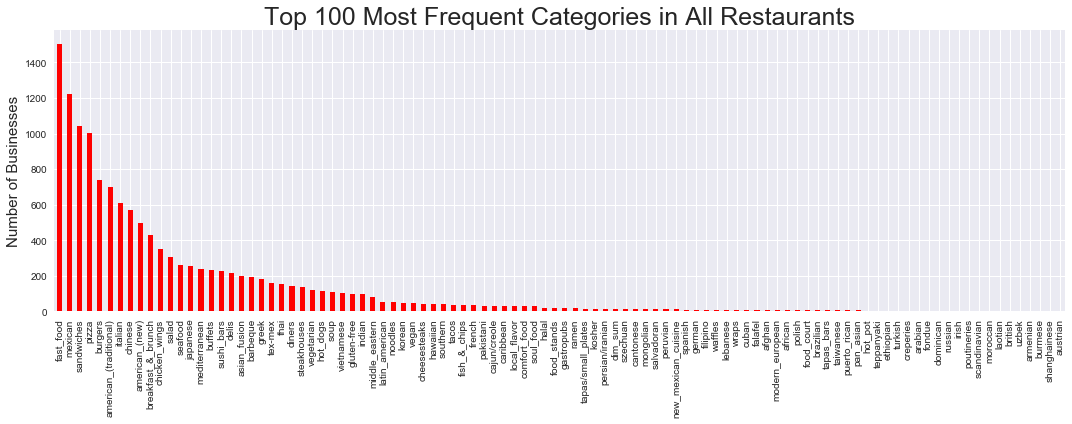

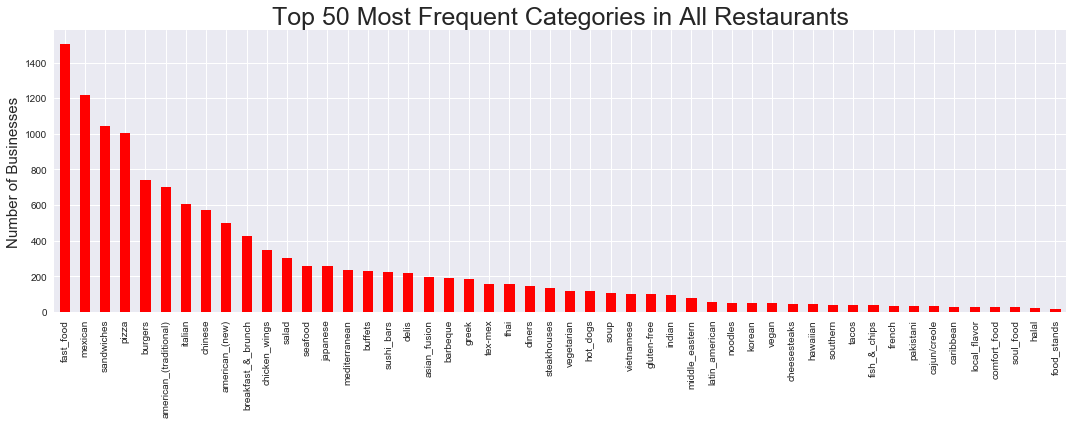

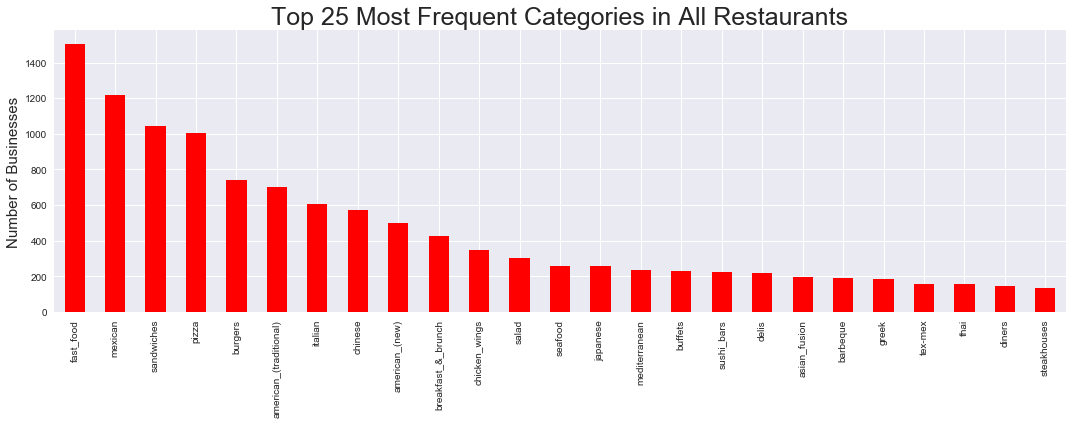

In [17]:
plot_category_counts(category_count_df, top_n_categories=100, title_suffix = 'All Restaurants', file_name='all_restaurants', color='r')
plot_category_counts(category_count_df, top_n_categories=50, title_suffix = 'All Restaurants', file_name='all_restaurants', color='r')
plot_category_counts(category_count_df, top_n_categories=25, title_suffix = 'All Restaurants', file_name='all_restaurants', color='r')

# Step 6: Tagging Fast Food Restaurants

<p>Create a `is_fast_food` column and if `fast_food` is found in a restaurant record's category list, set value to 1, else 0. Create pandas DataFrame for `non_fast_food_restaurants` and `fast_food_restaurants` accordingly.<p/>

In [18]:
non_fast_food_restaurants = restaurant_df[restaurant_df.categories.apply(lambda x: 'fast_food' not in x)].copy()
non_fast_food_restaurants['is_fast_food'] = 0

fast_food_restaurants = restaurant_df[restaurant_df.categories.apply(lambda x: 'fast_food' in x)].copy()
fast_food_restaurants['is_fast_food'] = 1

restaurant_df = pd.concat([non_fast_food_restaurants, fast_food_restaurants])
restaurant_df.reset_index(inplace=True, drop=True)

# Step 7: Identifying Most Frequent `categories` values in Fast Food Restaurants

In [19]:
ff_category_count_df = get_category_counts(fast_food_restaurants, drop_categories=['restaurants', 'fast_food'])

[19:27:58.310039] getting list of all categories
[19:27:58.311165] counting occurances of each category
[19:27:58.312238] making data frame of category counts


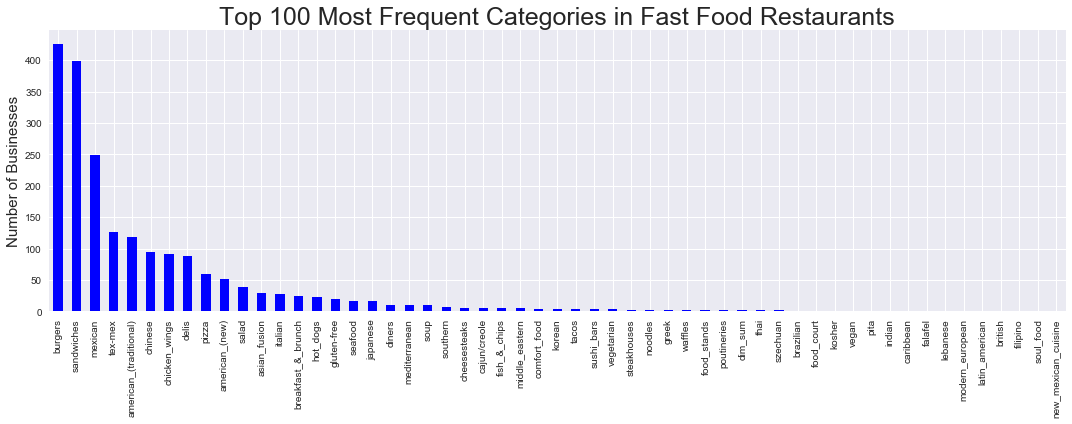

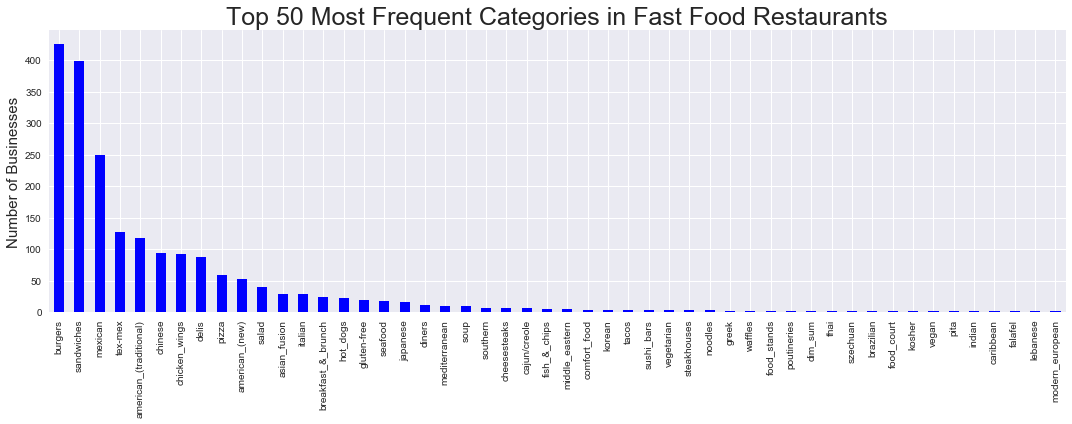

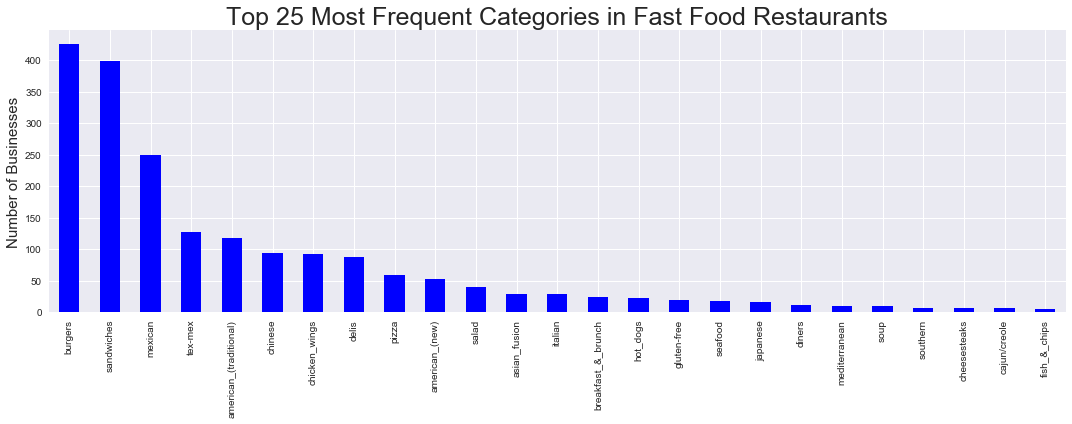

In [20]:
plot_category_counts(ff_category_count_df, top_n_categories=100, title_suffix = 'Fast Food Restaurants', file_name='ff_restaurants', color='b')
plot_category_counts(ff_category_count_df, top_n_categories=50, title_suffix = 'Fast Food Restaurants', file_name='ff_restaurants', color='b')
plot_category_counts(ff_category_count_df, top_n_categories=25, title_suffix = 'Fast Food Restaurants', file_name='ff_restaurants', color='b')

# Step 8: Identifying Most Frequent `categories` values in Non Fast Food Restaurants

In [21]:
nff_category_count_df = get_category_counts(non_fast_food_restaurants, drop_categories=['restaurants'])

[19:28:01.091525] getting list of all categories
[19:28:01.093335] counting occurances of each category
[19:28:01.096903] making data frame of category counts


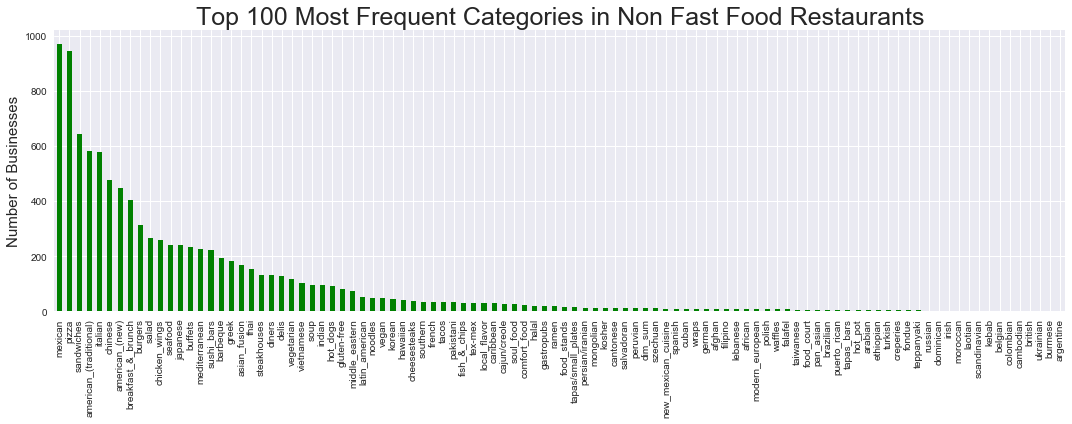

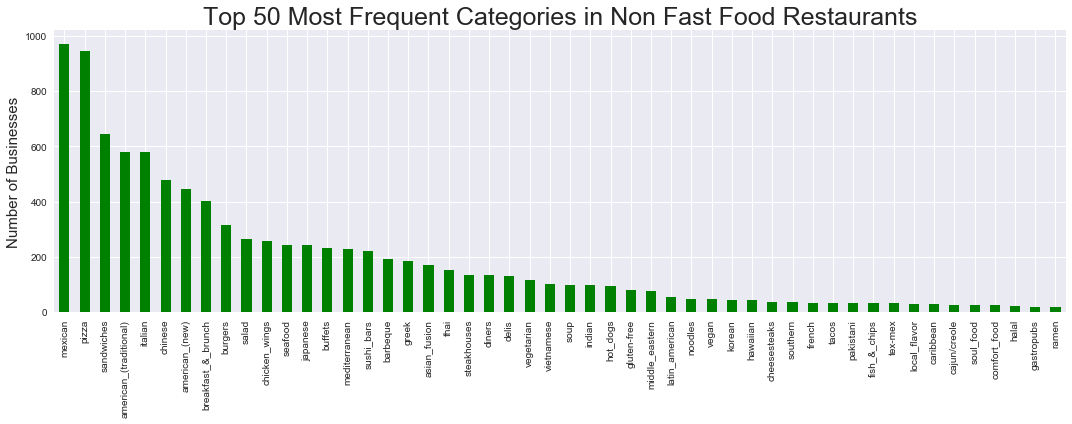

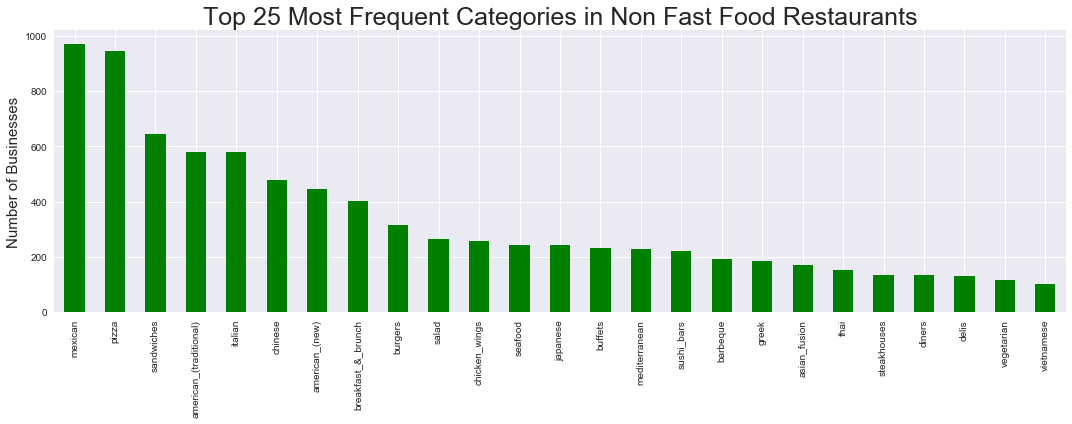

In [22]:
plot_category_counts(nff_category_count_df, top_n_categories=100, title_suffix = 'Non Fast Food Restaurants', file_name='nff_restaurants', color='g')
plot_category_counts(nff_category_count_df, top_n_categories=50, title_suffix = 'Non Fast Food Restaurants', file_name='nff_restaurants', color='g')
plot_category_counts(nff_category_count_df, top_n_categories=25, title_suffix = 'Non Fast Food Restaurants', file_name='nff_restaurants', color='g')

# Step 9: Write Cleaned `restaurant_df` DataFrame to csv file

In [29]:
restaurant_df.head()


,address,business_id,categories,city,is_open,name,postal_code,review_count,stars,is_fast_food
0,777 E Thunderbird Rd Ste 107,1WBkAuQg81kokZIPMpn9Zg,"[burgers, restaurants]",Phoenix,1,Charr An American Burger Bar,85022,232,3.0,0
1,10720 E Southern Ave,kKx8iCJkomVQBdWHnmmOiA,"[restaurants, pizza]",Mesa,1,Little Caesars Pizza,85209,4,2.5,0
2,8140 N Hayden Rd Ste H115,VdlPZg2NAu8t8GkdbPLecg,"[restaurants, gluten-free, indian, seafood]",Scottsdale,1,Tandoori Times Indian Bistro,85258,263,3.5,0
3,2810 North 75th Ave,QkG3KUXwqZBW18A9k1xqCA,"[american_(traditional), restaurants, seafood]",Phoenix,1,Red Lobster,85035,37,2.5,0
4,1455 W Elliot Rd,nigYwB_m1TQ1WosjSWi-Hw,"[burgers, restaurants]",Gilbert,0,Simply Burgers,85233,5,3.0,0


In [23]:
file_name = '../clean_data/az_restaurant_business_clean.csv'
time_marker(text='Writing {:d} records to file {}'.format(restaurant_df.shape[0], file_name))
restaurant_df.to_csv(file_name, encoding='utf-8')

time_marker('done!')

[19:28:04.504009] writing 7066 records to file ../clean_data/az_restaurant_business_clean.csv
[19:28:04.594880] done!


In [24]:
restaurant_df.head()

,address,business_id,categories,city,is_open,name,postal_code,review_count,stars,is_fast_food
0,777 E Thunderbird Rd Ste 107,1WBkAuQg81kokZIPMpn9Zg,"[burgers, restaurants]",Phoenix,1,Charr An American Burger Bar,85022,232,3.0,0
1,10720 E Southern Ave,kKx8iCJkomVQBdWHnmmOiA,"[restaurants, pizza]",Mesa,1,Little Caesars Pizza,85209,4,2.5,0
2,8140 N Hayden Rd Ste H115,VdlPZg2NAu8t8GkdbPLecg,"[restaurants, gluten-free, indian, seafood]",Scottsdale,1,Tandoori Times Indian Bistro,85258,263,3.5,0
3,2810 North 75th Ave,QkG3KUXwqZBW18A9k1xqCA,"[american_(traditional), restaurants, seafood]",Phoenix,1,Red Lobster,85035,37,2.5,0
4,1455 W Elliot Rd,nigYwB_m1TQ1WosjSWi-Hw,"[burgers, restaurants]",Gilbert,0,Simply Burgers,85233,5,3.0,0


In [25]:
non_fast_food_restaurants.head()

,address,business_id,categories,city,is_open,name,postal_code,review_count,stars,is_fast_food
1,777 E Thunderbird Rd Ste 107,1WBkAuQg81kokZIPMpn9Zg,"[burgers, restaurants]",Phoenix,1,Charr An American Burger Bar,85022,232,3.0,0
3,10720 E Southern Ave,kKx8iCJkomVQBdWHnmmOiA,"[restaurants, pizza]",Mesa,1,Little Caesars Pizza,85209,4,2.5,0
4,8140 N Hayden Rd Ste H115,VdlPZg2NAu8t8GkdbPLecg,"[restaurants, gluten-free, indian, seafood]",Scottsdale,1,Tandoori Times Indian Bistro,85258,263,3.5,0
5,2810 North 75th Ave,QkG3KUXwqZBW18A9k1xqCA,"[american_(traditional), restaurants, seafood]",Phoenix,1,Red Lobster,85035,37,2.5,0
6,1455 W Elliot Rd,nigYwB_m1TQ1WosjSWi-Hw,"[burgers, restaurants]",Gilbert,0,Simply Burgers,85233,5,3.0,0


In [26]:
fast_food_restaurants.head()

,address,business_id,categories,city,is_open,name,postal_code,review_count,stars,is_fast_food
0,719 E Thunderbird Rd,rDMptJYWtnMhpQu_rRXHng,"[fast_food, burgers, restaurants]",Phoenix,1,McDonald's,85022,10,1.0,1
2,1635 E Camelback Rd,iPa__LOhse-hobC2Xmp-Kw,"[restaurants, burgers, fast_food]",Phoenix,1,McDonald's,85016,34,3.0,1
7,3441 W Northern Ave,2v-8QQfMLX2PCz-0S6gISQ,"[pizza, restaurants, fast_food]",Phoenix,1,Papa John's Pizza,85051,7,2.5,1
19,1483 N Dysart Rd,mfQlXkeNhW1vz_1iq63mNQ,"[restaurants, fast_food, mexican]",Avondale,1,Del Taco,85323,23,2.5,1
21,17032 N 99th Ave,6CpAWkTcqqNtGAfOsPeFUw,"[american_(traditional), restaurants, sandwich...",Sun City,1,Arby's,85373,9,3.5,1


# Step 10: Inspect Star Distribution
<ul>
    <li>All Restaurants</li>
    <li>Fast Food Restaurants</li>
    <li>Non Fast Food Restaurants</li>
</ul>

In [27]:
def plot_rating_distribution(df, title_suffix = '', file_name='test', color='k'):
    
    df = df.groupby('stars').count()['business_id'].copy()
    df = df/df.max()
    
    ax = df.plot(kind='bar', figsize=FIG_SIZE, color=color)
    
    if len(title_suffix) > 0:
        ax.set_title('Business Star Distribution in {}'.format(title_suffix), size=TITLE_FONT_SIZE)
    else:
        ax.set_title('Business Star Distribution', size=TITLE_FONT_SIZE)
        
    ax.set_ylabel('Distribution', size=LABEL_FONT_SIZE)
    ax.set_xlabel('Restaurant Star Rating', size=LABEL_FONT_SIZE)
    ax.set_xticklabels(df.index.values, size=TICK_FONT_SIZE, rotation=0)
    ax.legend('')
    plt.tight_layout()
    if DO_WRITE_CHARTS:
        plt.savefig('../charts/{}_business_star_distribution.png'.format(file_name))
    plt.show()
    plt.close()


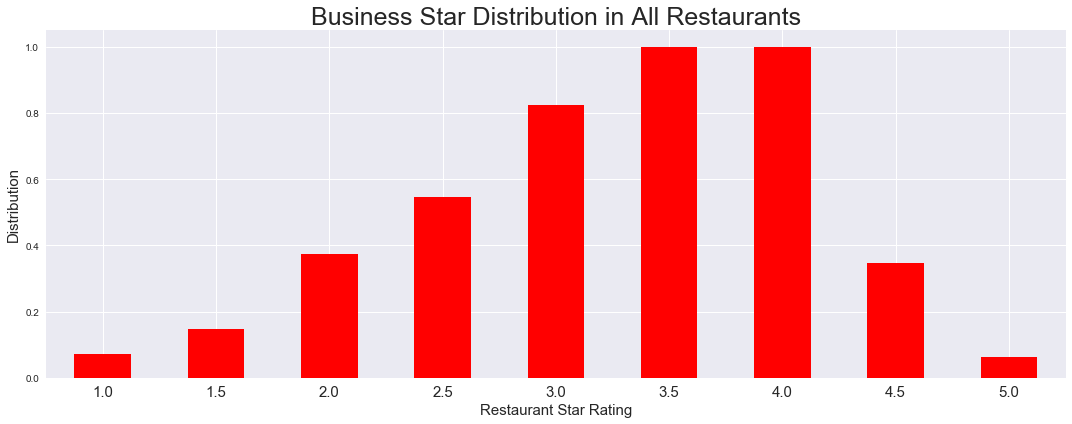

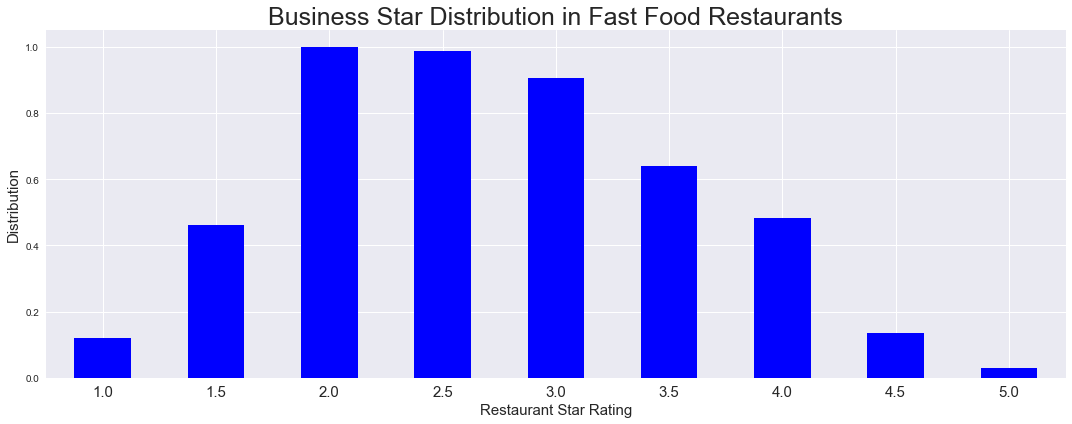

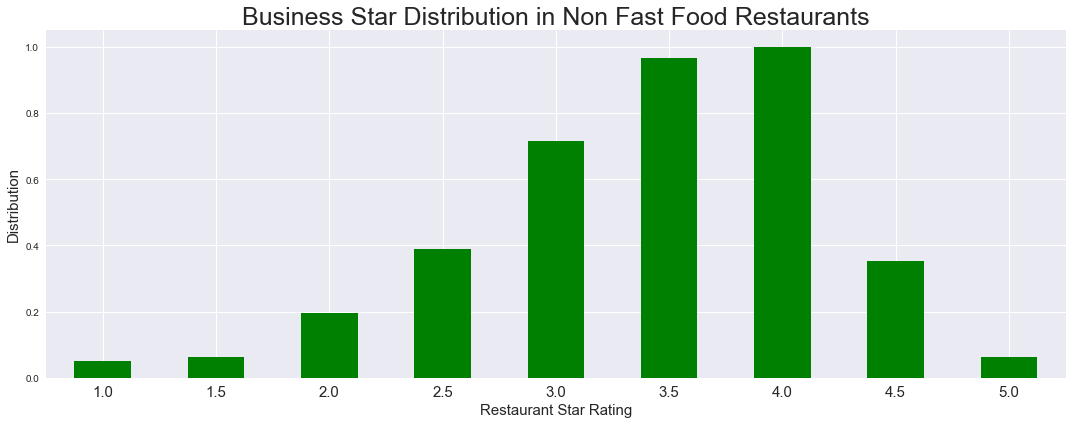

In [28]:
plot_rating_distribution(restaurant_df, title_suffix = 'All Restaurants', file_name='all_restaurants', color='r')
plot_rating_distribution(fast_food_restaurants, title_suffix = 'Fast Food Restaurants', file_name='ff_restaurants', color='b')
plot_rating_distribution(non_fast_food_restaurants, title_suffix = 'Non Fast Food Restaurants', file_name='nff_restaurants', color='g')